In [8]:
import math
import os

import numpy as np
import matplotlib.pyplot as plt
import pickle
import joblib
from numpy import resize
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from keras.applications import VGG16  # Example: VGG16 model
from keras.models import Model
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from sklearn.decomposition import PCA

## Loading VGG16 pretrained model

In [9]:
# Cataract, Glaucoma are of 256x256
# Diabetic_retinopathy, Normal are of 512x512

# # Defining the image dimensions
image_height = 256
image_width = 256
#
# # Load the pre-trained CNN model:
#
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))
print('VGG16 model loaded')
#
# # Creating a new model for feature extraction
#
model = Model(inputs=base_model.input, outputs=base_model.output)
print('model initiated')


VGG16 model loaded
model initiated


### Preprocessing image

In [10]:
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(image_height, image_width, 3))
    imgee_array = image.img_to_array(img)
    imgee_array = preprocess_input(imgee_array)
    return imgee_array

In [11]:
def extract_features_from_dataset(datasetdirectory):
    features = []

    for class_folder in os.listdir(datasetdirectory):
        class_path = os.path.join(datasetdirectory, class_folder)
        print('Processing class folder: {}'.format(class_path))
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img_array = load_and_preprocess_image(img_path)
            img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
            features.append(model.predict(img_array).flatten())  # Extract features using the model
    print('Features loaded')

    return np.array(features)

## Extracting features

In [12]:
# # Extract features from the dataset
# extracted_features = extract_features_from_dataset('eye_diseases')
# print(extracted_features)
# np.save('extracted_features2.npy', extracted_features)

extracted_features = np.load('extracted_features2.npy')

## Fitting the Kmeans Model

In [13]:
n_clusters = 4  # Number of clusters ('cataract', 'diabetic_retinopathy', 'glaucoma', 'normal')
# kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
# Fitting the features
# print('Fitting features...')
# kmeans.fit(extracted_features)
# print('Saving model...')
# joblib.dump(kmeans, 'kmeans.pkl')
# print('Kmeans model saved.')
kmeans = joblib.load('kmeans.pkl')
print(kmeans.cluster_centers_.shape)
print(kmeans.inertia_)

(4, 32768)
2052000768.0


### Trying to revert the extraction

In [28]:
intermediate_layer = 'block5_conv3'
upsample_model = Model(inputs=model.input, outputs=model.get_layer(intermediate_layer).output)
original_image = image.load_img("eye_diseases\glaucoma\_0_4517448.jpg", target_size=(image_height, image_width, 3))
original_image = image.img_to_array(original_image)

img_array = load_and_preprocess_image("eye_diseases\glaucoma\_0_4517448.jpg")
img_array = np.expand_dims(img_array, axis=0)
print(img_array.shape)
img_feature = model.predict(img_array).flatten()
x = kmeans.predict(img_feature.reshape(1, -1))
print(x)
print(kmeans.cluster_centers_)

scaler = MinMaxScaler(feature_range=(0, 255))

upsampled_features = scaler.fit_transform(kmeans.cluster_centers_[x])
print(upsampled_features.shape)
upsampled_features = resize(upsampled_features, (1, 256, 256, 3))
upsampled_features = upsample_model.predict(upsampled_features)
upsampled_features = resize(upsampled_features, (1, 256, 256, 3))


(1, 256, 256, 3)
1/1 [==============================] - 0s 279ms/step
[3]
[[ 1.8160790e-08  0.0000000e+00 -8.3819032e-08 ...  4.0215142e-03
   7.5021710e+00 -6.5192580e-09]
 [-9.7788870e-09  0.0000000e+00  1.3038516e-08 ... -1.2805685e-09
   1.8452454e-01 -5.8207661e-09]
 [ 3.0159462e-02  0.0000000e+00  1.4832678e-01 ... -1.2805685e-09
   1.4052162e+01  1.9014090e-02]
 [ 1.3038516e-08  0.0000000e+00 -8.3819032e-08 ...  4.4237822e-09
   6.2625976e+00 -5.1222742e-09]]
(1, 32768)
1/1 [==============================] - 0s 322ms/step


## Visualize the clusters centroids

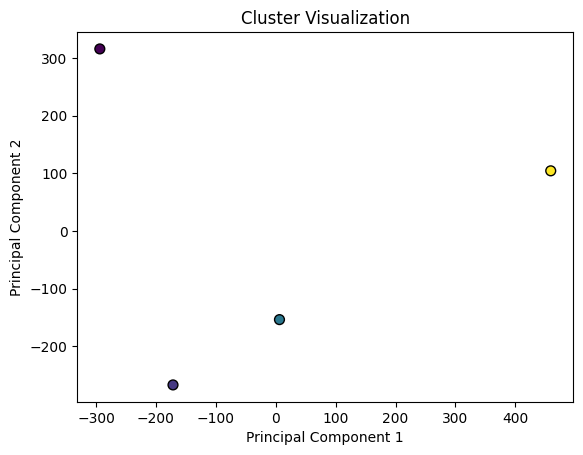

In [29]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(kmeans.cluster_centers_)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=[i for i in X_pca[:, 0]], cmap='viridis', edgecolor='k', s=50)
plt.title('Cluster Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## Visualize features in 2D

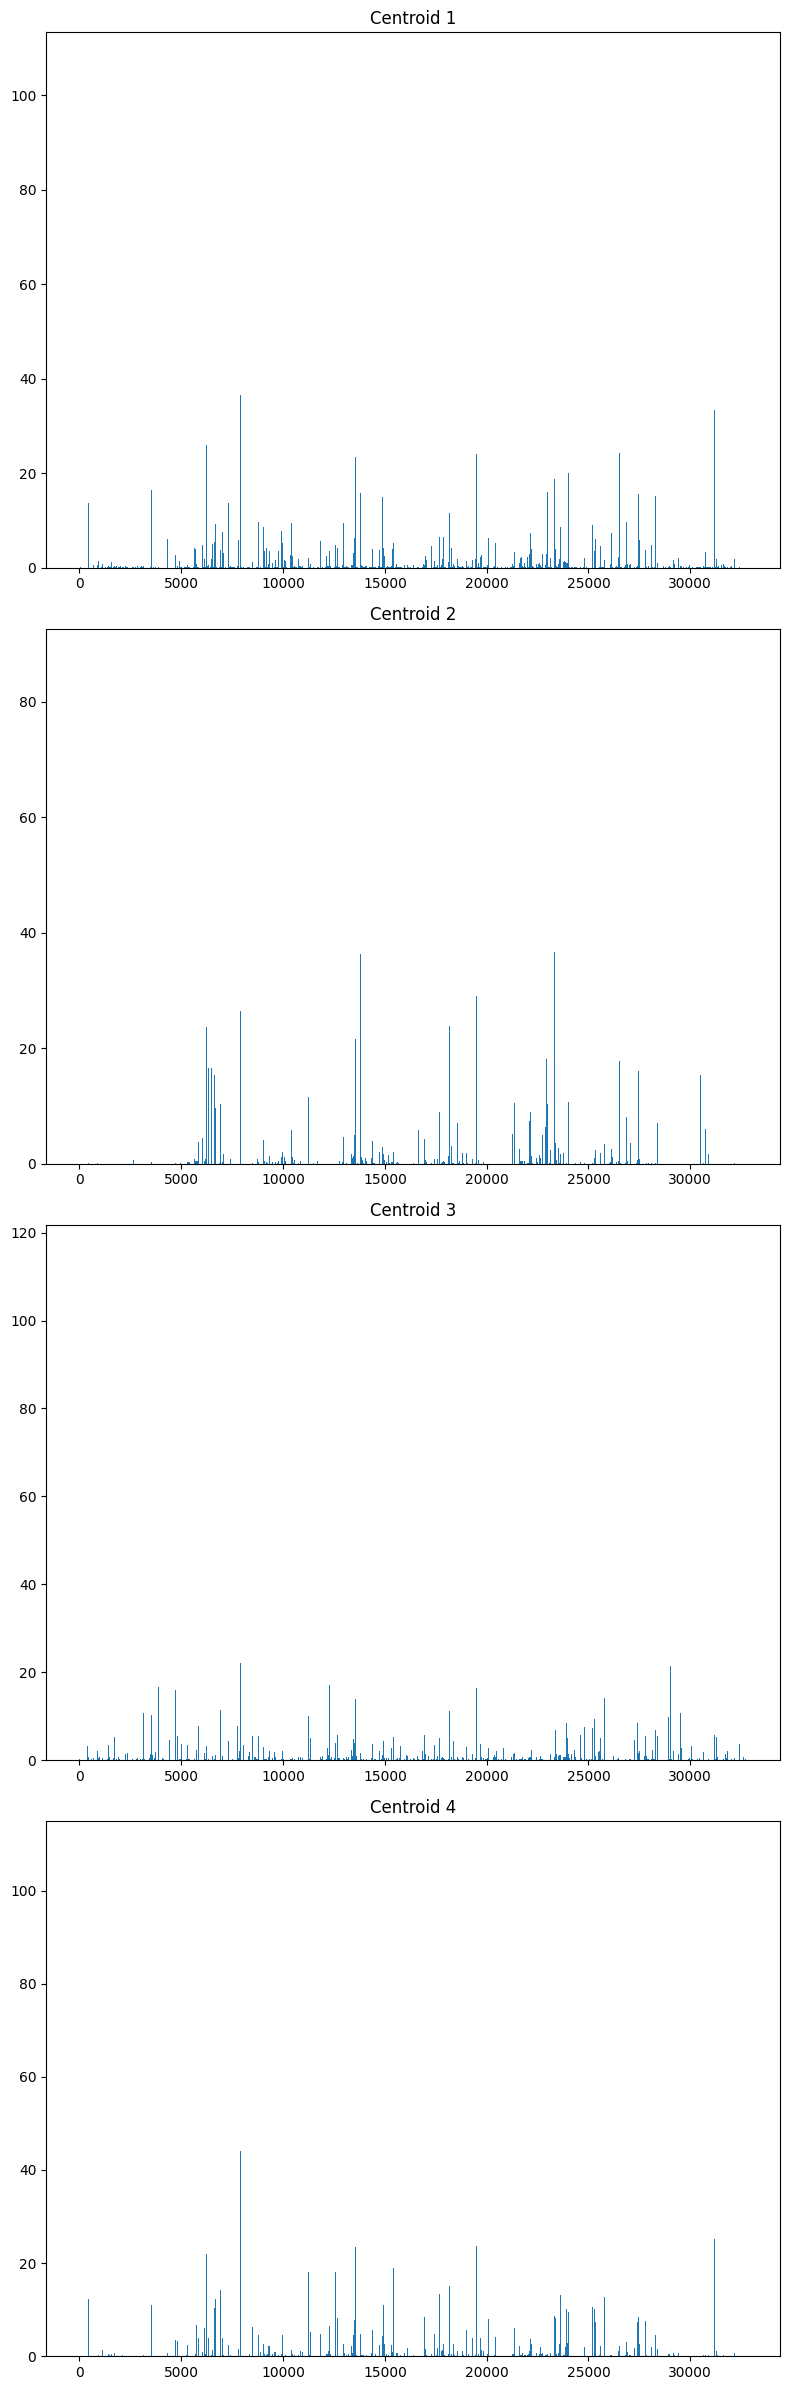

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the centroids as features
centroids = kmeans.cluster_centers_

# Assuming you have feature names for each centroid feature
feature_names = [i for i in range(32768)]  # Replace ... with actual feature names

num_clusters = len(centroids)
num_features = len(centroids[0])

# Plotting centroids as bar charts
fig, axs = plt.subplots(num_clusters, figsize=(8, 24))

for i in range(num_clusters):
    axs[i].bar(feature_names, centroids[i])
    axs[i].set_title(f'Centroid {i+1}')

plt.tight_layout()
plt.show()
